<a href="https://colab.research.google.com/github/abagnard/266FinalProject/blob/main/W266_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:

import os, sys, re, csv, json, time, unittest
import itertools, collections
from importlib import reload

import numpy as np
from scipy import stats
import pandas as pd

import nltk



# FOMC Data Loader

## Scrape FOMC Data

#### Links to Data:
**Start-2014:** https://www.federalreserve.gov/monetarypolicy/fomc_historical_year.htm
**2015-2020:** https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm

#### 2010-2020 General Link Format:
  **Statement/Press Release:** https://www.federalreserve.gov/newsevents/pressreleases/monetaryYYYYMMDDa.htm
   **Minutes:** https://www.federalreserve.gov/monetarypolicy/fomcminutesYYYYMMDD.htm

In [98]:
from   bs4    import BeautifulSoup
from   urllib.request import urlopen

# Create URLs
def getFOMCStatementURL(date):
  if date >= 20100000:
    url = "https://www.federalreserve.gov/newsevents/pressreleases/monetary" + str(date) + "a.htm"
  return url

def getFOMCMinutesURL(date):
  if date >= 20100000:
    url = "https://www.federalreserve.gov/monetarypolicy/fomcminutes" + str(date) + ".htm"
  return url

# Pull Data from URL
def getFOMCStatementData(date):
    html = urlopen(getFOMCStatementURL(date)).read()
    soup = BeautifulSoup(html)
    text = soup.get_text(" ")
    if int(date) < 20200400:
        startLocation = re.search("Information received since", text).start()
    else:
        startLocation = re.search("The Federal Reserve is committed", text).start()
    endLocation = re.search("Voting for", text).start()

    statementText = text[startLocation : endLocation]
    return statementText

def getFOMCMinutesData(date):
  html = urlopen(getFOMCMinutesURL(date)).read()
  soup = BeautifulSoup(html)
  text = soup.get_text(" ")

  startLocation = re.search("Minutes of the Federal Open Market Committee", text).start() + len("Minutes of the Federal Open Market Committee")
  endLocation = re.search("notation vote", text).start()

  minutesText = text[startLocation : endLocation]
  return minutesText


In [99]:
# from google.colab import drive
# drive.mount('/content/drive')


In [100]:
# dates = [20100127
# ,20100316
# ,20100428]
# for date in dates:
#   print("Statement on ", date)
#   print(getFOMCStatementData(date))


# for date in dates:
#   print("Minutes on ", date)
#   print(getFOMCMinutesData(date))


### Code for Google Colab
#### Pulls Dates from Google Sheets

In [101]:
# Code Source
# https://medium.com/analytics-vidhya/colab-and-google-sheets-surprisingly-powerful-combination-for-data-science-part-1-bbbb11cbd8e

# from google.colab import auth
# auth.authenticate_user()
# import gspread
# from oauth2client.client import GoogleCredentials
# gc = gspread.authorize(GoogleCredentials.get_application_default())

In [102]:
# date_google_sheet_url = gc.open_by_url("https://docs.google.com/spreadsheets/d/1Q9_JimVaDffFe8U4SYQ_VLU9-1aeuFXlDZhvTsFD0kg/edit#gid=1023419829")
# date_google_sheet = date_google_sheet_url.worksheet("Dates")
# date_data_raw = date_google_sheet.get_all_values()

# df_date = pd.DataFrame(date_data_raw)
# df_date.columns = df_date.iloc[0]
# df_date = df_date.iloc[1:]

# df_date.head()
# dates = df_date["Date"].values.tolist()

#### Create Raw Text Files

In [103]:
# Pull Dates of FOMC meetings
df_date = pd.read_csv("data/FOMC_data/FOMC_meeting_dates.csv")
df_date.head()
meeting_dates = df_date["MeetingDate"].values.tolist()

# Functions to create Statement and Minute Text Files
def createFOMCStatementTextFile(file_path):
#   file_path = "/content/drive/My Drive/W266 - NLP/Final Project/data/FOMC_data/FOMC_Raw/"
#     file_path = "data/FOMC_data/FOMC_data_raw/"
    for date in meeting_dates:
        print("Creating Text File: Statement - ", date)
        data = getFOMCStatementData(date)
        filename = "FOMCStatement_" + str(date) + ".txt"
        file = open(file_path+filename, "w")
        file.write(data)
        file.close
        
def createFOMCMinutesTextFile(file_path):
#   file_path = "/content/drive/My Drive/W266 - NLP/Final Project/data/FOMC_data/FOMC_Raw/"
#     file_path = "data/FOMC_data/FOMC_data_raw/"
    for date in meeting_dates:
        print("Creating Text File: Minute - ", date)
        data = getFOMCMinutesData(date)
        filename = "FOMCMinutes_" + str(date) + ".txt"
        file = open(file_path+filename, "w")
        file.write(data)
        file.close
df_date.head()
# createFOMCStatementTextFile(file_path = "data/FOMC_data/FOMC_data_raw/")
# createFOMCMinutesTextFile(file_path = "data/FOMC_data/FOMC_data_raw/")

,MeetingDate,MinuteNotesReleaseDate,PressConference
0,20100127,20100217,0
1,20100316,20100406,0
2,20100428,20100519,0
3,20100623,20100714,0
4,20100810,20100831,0


In [104]:
# from google.colab import drive
# drive.mount('/content/drive')
# cd /content/drive/'My Drive'/'W266 - NLP'/'Final Project'

## Clean Raw Text Files
- Removes punctuation and stop words
- Renames "federal open market committee" and "the committee" as "FOMC"
- Creates clean text files where text is all lowercase

In [123]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import glob

def cleanFOMCDocument(raw_file_name):
    raw_data = open(raw_file_name,"r").read().lower()
    clean_data = raw_data
    
    #remove punctuation, stopwords and returns test as lowercase words
#     for todelete in ["\r\n", "\n", "\t", ",", "-", ";", ":", "  "]:
#         clean_data = clean_data.replace(todelete, ' ')
        
    tokenizer = RegexpTokenizer(r'\w+')
    clean_data = tokenizer.tokenize(clean_data)
    
    clean_data = [word for word in clean_data if word not in stopwords.words('english')]
    clean_data = " ".join(clean_data)
    
    clean_data = clean_data.replace("federal open market committee", "FOMC")
    clean_data = clean_data.replace("the committee", "the FOMC")
    return clean_data


def createCleanFOMCTextFiles(raw_file_names):
    file_path = 'data/FOMC_data/FOMC_data_clean/FOMC_data_clean_without_stopwords/'
    
    for raw_file_name in raw_file_names:
        file_name = raw_file_name.split('/')[-1]
        print("Creating Text File: ", file_name)
        data = cleanFOMCDocument(raw_file_name)

        file = open(file_path+file_name, "w")
        file.write(data)
        file.close
        
raw_file_names = glob.glob('data/FOMC_data/FOMC_data_raw/*.txt')
# print(sorted(stopwords.words('english')))
createCleanFOMCTextFiles(raw_file_names)
# print(cleanFOMCDocument('data/FOMC_data/FOMC_data_raw/FOMCMinutes_20100316.txt'))

Creating Text File:  FOMCStatement_20110126.txt
Creating Text File:  FOMCStatement_20130619.txt
Creating Text File:  FOMCMinutes_20170726.txt
Creating Text File:  FOMCStatement_20170201.txt
Creating Text File:  FOMCStatement_20180131.txt
Creating Text File:  FOMCMinutes_20120313.txt
Creating Text File:  FOMCStatement_20120620.txt
Creating Text File:  FOMCMinutes_20140430.txt
Creating Text File:  FOMCMinutes_20121024.txt
Creating Text File:  FOMCStatement_20101214.txt
Creating Text File:  FOMCStatement_20150729.txt
Creating Text File:  FOMCStatement_20160615.txt
Creating Text File:  FOMCStatement_20200429.txt
Creating Text File:  FOMCStatement_20111213.txt
Creating Text File:  FOMCStatement_20190731.txt
Creating Text File:  FOMCStatement_20140129.txt
Creating Text File:  FOMCStatement_20190320.txt
Creating Text File:  FOMCMinutes_20140618.txt
Creating Text File:  FOMCMinutes_20160127.txt
Creating Text File:  FOMCStatement_20200610.txt
Creating Text File:  FOMCMinutes_20181108.txt
Creati

## Create DataFrame with Clean Data
- Includes press_conference flag that denotes whether a press conference was held for that FOMC meeting

In [124]:
clean_file_names = glob.glob('data/FOMC_data/FOMC_data_clean/FOMC_data_clean_without_stopwords/*.txt')

FOMC_records = []
for clean_file_name in clean_file_names:
    meeting_date = clean_file_name.split('/')[-1].split('_')[-1][:-4]
    file_type = 'minutes' if 'Minutes' in clean_file_name else 'statement'
    press_conference = df_date[df_date['MeetingDate'] == int(meeting_date)].iloc[0]['PressConference']
    
    release_date = meeting_date
    # for minute documents, update release_date to be the date the minute notes were released
    # press release documents were published the day of the meeting
    if file_type == 'minutes':
        release_date = df_date[df_date['MeetingDate'] == int(meeting_date)].iloc[0]['MinuteNotesReleaseDate']

    data = open(clean_file_name).read()
    
    FOMC_record = {'FOMC_date': meeting_date, 'release_date': release_date, 'document_type': file_type, 'press_conference': press_conference, 'document_data': data}
    FOMC_records.append(FOMC_record)


df_FOMC_raw = pd.DataFrame(FOMC_records)

In [125]:
df_FOMC_raw.FOMC_date = pd.to_datetime(df_FOMC_raw.FOMC_date, format='%Y%m%d')
df_FOMC_raw.release_date = pd.to_datetime(df_FOMC_raw.release_date, format='%Y%m%d')
df_FOMC_raw.head()

,FOMC_date,document_data,document_type,press_conference,release_date
0,2011-01-26,information received since FOMC met december c...,statement,0,2011-01-26
1,2013-06-19,information received since FOMC met may sugges...,statement,1,2013-06-19
2,2017-07-26,july 25 26 2017 joint meeting FOMC board gover...,minutes,0,2017-08-16
3,2017-02-01,information received since FOMC met december i...,statement,0,2017-02-01
4,2018-01-31,information received since FOMC met december i...,statement,0,2018-01-31


In [126]:
df_FOMC_raw.describe(include='all')
df_FOMC_raw.dtypes

FOMC_date           datetime64[ns]
document_data               object
document_type               object
press_conference             int64
release_date        datetime64[ns]
dtype: object

## Add Lables to DataFrame
- Label_Data file includes code on how we caluclate our data lables

In [127]:
df_market_data_lables = pd.read_csv('data/Market_data/market_data_labels_by_date.csv', parse_dates=['Date'])
df_market_data_lables.head()

,Date,open,high,low,close,volume,prevclose,pct_change_in_close,fed_rate,prev_fed_rate,pct_change_in_fed_rate,5_yr,7_yr,10_yr,20_yr,30_yr,prev_10_yr,pct_change_in_10_yr,label
0,2003-01-02,88.85,91.30,88.54,91.07,44516300,88.23,3.218860,1.30,1.16,10.769231,1.75,2.24,2.43,NaN,NaN,NaN,NaN,0
1,2003-01-03,90.91,91.38,90.50,91.35,32222600,91.07,0.307456,1.12,1.30,-16.071429,1.75,2.25,2.43,NaN,NaN,2.43,0.000000,1
2,2003-01-06,91.24,93.49,91.17,92.96,40984500,91.35,1.762452,1.22,1.12,8.196721,1.79,2.27,2.46,NaN,NaN,2.43,1.219512,3
3,2003-01-07,92.90,93.37,92.20,92.73,38640400,92.96,-0.247418,1.20,1.22,-1.666667,1.76,2.24,2.42,NaN,NaN,2.46,-1.652893,-3
4,2003-01-08,92.20,92.40,91.05,91.39,38702200,92.73,-1.445056,1.29,1.20,6.976744,1.68,2.14,2.29,NaN,NaN,2.42,-5.676856,-1


In [128]:
df_FOMC_labeled =  pd.merge(df_FOMC_raw, df_market_data_lables, left_on='release_date', right_on='Date')

In [129]:
df_FOMC_labeled.head()

,FOMC_date,document_data,document_type,press_conference,release_date,Date,open,high,low,close,...,prev_fed_rate,pct_change_in_fed_rate,5_yr,7_yr,10_yr,20_yr,30_yr,prev_10_yr,pct_change_in_10_yr,label
0,2011-01-26,information received since FOMC met december c...,statement,0,2011-01-26,2011-01-26,129.49,130.05,129.23,129.67,...,0.17,0.000000,0.07,0.65,1.16,1.82,2.07,1.11,4.310345,2
1,2013-06-19,information received since FOMC met may sugges...,statement,1,2013-06-19,2013-06-19,165.60,165.89,163.38,163.45,...,0.12,-20.000000,-0.59,-0.19,0.29,1.05,1.26,0.14,51.724138,-1
2,2017-07-26,july 25 26 2017 joint meeting FOMC board gover...,minutes,0,2017-08-16,2017-08-16,247.11,247.57,246.45,246.94,...,1.16,0.000000,0.17,0.34,0.45,0.75,0.94,0.49,-8.888889,0
3,2017-02-01,information received since FOMC met december i...,statement,0,2017-02-01,2017-02-01,227.53,228.59,226.94,227.62,...,0.56,15.151515,0.01,0.31,0.43,0.77,0.96,0.40,6.976744,3
4,2018-01-31,information received since FOMC met december i...,statement,0,2018-01-31,2018-01-31,282.73,283.30,280.68,281.90,...,1.42,-5.970149,0.54,0.60,0.61,0.72,0.80,0.63,-3.278689,-1


In [130]:
df_FOMC_labeled_small = df_FOMC_labeled[['FOMC_date', 'document_data', 'document_type', 'press_conference', 'release_date','label']].copy()
df_FOMC = df_FOMC_labeled_small
df_FOMC.head()

,FOMC_date,document_data,document_type,press_conference,release_date,label
0,2011-01-26,information received since FOMC met december c...,statement,0,2011-01-26,2
1,2013-06-19,information received since FOMC met may sugges...,statement,1,2013-06-19,-1
2,2017-07-26,july 25 26 2017 joint meeting FOMC board gover...,minutes,0,2017-08-16,0
3,2017-02-01,information received since FOMC met december i...,statement,0,2017-02-01,3
4,2018-01-31,information received since FOMC met december i...,statement,0,2018-01-31,-1


# Top 20 Most Common Words

In [131]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 20)

cv.fit(df_FOMC['document_data'])
top_20_words_all = cv.get_feature_names()

top_20_words_all = pd.DataFrame(top_20_words_all)
top_20_words_all.columns = ['Top 20 Words']
top_20_words_all

# top_20 = pd.DataFrame(results.toarray(). columns=features)

,Top 20 Words
0,board
1,committee
2,conditions
3,continued
4,economic
5,federal
6,financial
7,inflation
8,labor
9,longer


# FOMC Word Cloud

### FOMC Statements & Minutes Word Cloud

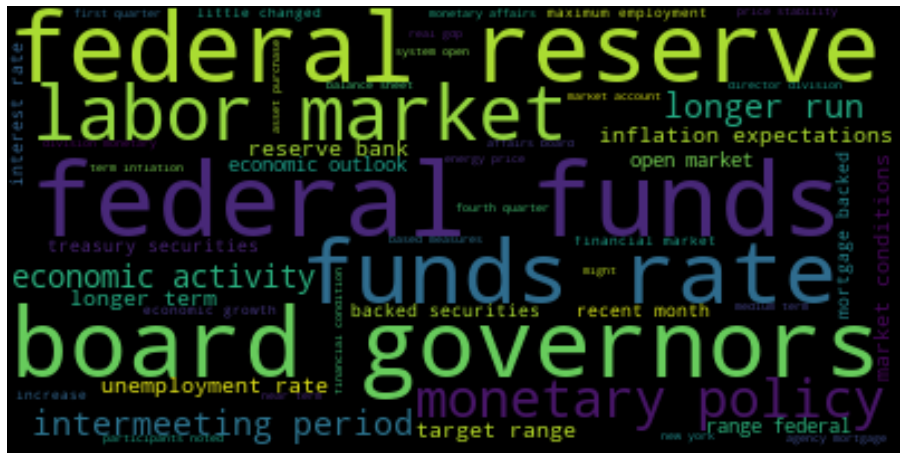

In [132]:
# pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

text = ' '.join(df_FOMC['document_data'])
wordcloud = WordCloud(max_words=50).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/all_FOMC_docs_wordcloud.png")

### FOMC Statements Word Cloud

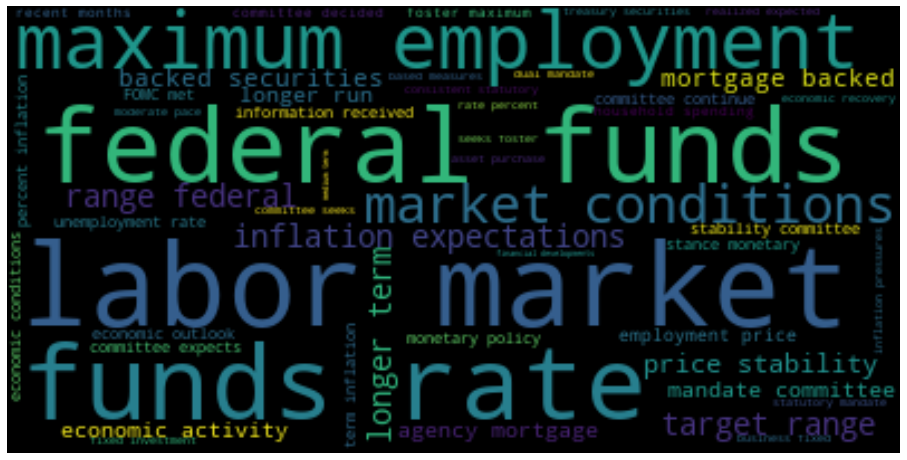

In [133]:
statements = df_FOMC[df_FOMC['document_type'] == 'statement']

plt.figure(figsize=(16, 10))

statement_text = ' '.join(statements['document_data'])
statement_wordcloud = WordCloud(max_words=50).generate(statement_text)
plt.imshow(statement_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_statements_wordcloud.png")

### FOMC Minutes Word Cloud

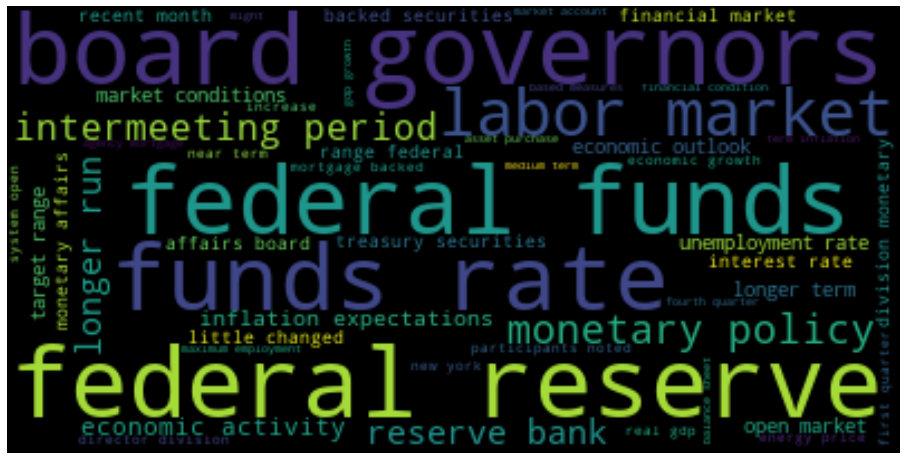

In [134]:
minutes = df_FOMC[df_FOMC['document_type'] == 'minutes']

plt.figure(figsize=(16, 10))

minute_text = ' '.join(minutes['document_data'])
minute_wordcloud = WordCloud(max_words=50).generate(minute_text)
# minute_wordcloud = WordCloud(max_words=50, background_color='white').generate(minute_text)
plt.imshow(minute_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_minutes_wordcloud.png"

# Document Sentiment Analysis

#### Load Loughran-McDonald Postive & Negative Word Lists
source: https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists

In [135]:
df_FOMC_sentiment = df_FOMC

In [136]:
def createLoughranMcDonaldWordList(file_name):
    file = open('data/LoughranMcDonald/'+file_name, "r")
    words = file.readlines()
    words = [word.strip().lower() for word in words]
    return words

LM_negative_words = createLoughranMcDonaldWordList('LoughranMcDonald_NegativeWordList.csv')
LM_postive_words = createLoughranMcDonaldWordList('LoughranMcDonald_PositiveWordList.csv')

#### Count Positive and Negative Words in Each Document to Calculate Sentiment Score

In [137]:
def calcSentiment(document_data):
    words = document_data.split(' ')
    positive_words = [word for word in words if word in LM_postive_words]
    negative_words = [word for word in words if word in LM_negative_words]
#     positive_count = len(positive_words)
#     negative_count = len(negative_words)
    sentiment_score = len(positive_words) - len(negative_words)
    return [sentiment_score, positive_words, negative_words]

df_FOMC_sentiment['sentiment_score'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[0])
df_FOMC['LM_positive_words'] = df_FOMC['document_data'].apply(lambda data: calcSentiment(data)[1])
df_FOMC['LM_netagive_words'] = df_FOMC['document_data'].apply(lambda data: calcSentiment(data)[2])
# df_FOMC['LM_neutral_words'] = 

In [138]:
df_FOMC_sentiment.sort_values(['FOMC_date', 'document_type']).head()

,FOMC_date,document_data,document_type,press_conference,release_date,label,sentiment_score,LM_positive_words,LM_netagive_words
114,2010-01-27,january 26 27 2010 fomc minutes summary econom...,minutes,0,2010-02-17,1,-83,"[pleasure, satisfactory, effective, effective,...","[discontinuance, cease, suspended, limitations..."
39,2010-01-27,information received since FOMC met december s...,statement,0,2010-01-27,2,5,"[strengthen, better, stability, stable, stable...","[deterioration, weak, reluctant, slowing, clos..."
55,2010-03-16,march 16 2010 fomc minutes joint meeting FOMC ...,minutes,0,2010-04-06,0,-80,"[smoothly, strong, favorable, progress, streng...","[strains, closing, closed, strain, decline, de..."
146,2010-03-16,information received since FOMC met january su...,statement,0,2010-03-16,0,3,"[strengthen, stabilizing, stability, stable, s...","[unemployment, declining, depressed, reluctant..."
38,2010-04-28,april 27 28 2010 fomc minutes summary economic...,minutes,0,2010-05-19,-1,-42,"[progress, accomplishing, achievement, stabili...","[terminate, postpone, crisis, disruptions, slo..."


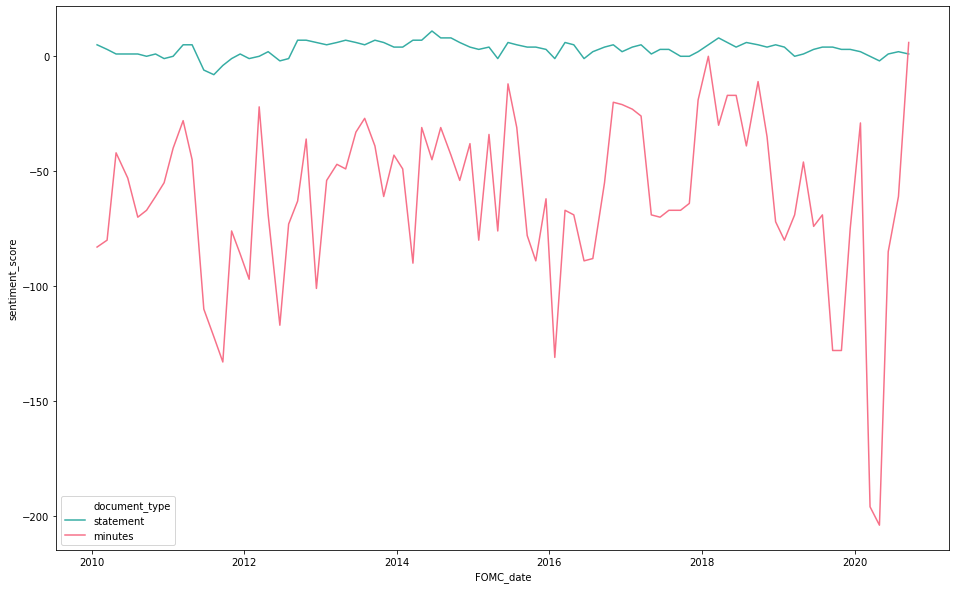

In [139]:

df_FOMC_sentiment.sort_values(['FOMC_date', 'document_type']).head()

import seaborn as sns
colors = sns.color_palette('husl', n_colors =2)
color_map = dict(zip(['minutes','statement'], colors))

plt.figure(figsize=(16, 10))
sns.lineplot(x=df_FOMC_sentiment['FOMC_date'], y=df_FOMC_sentiment['sentiment_score'], hue=df_FOMC_sentiment['document_type'], palette=color_map)


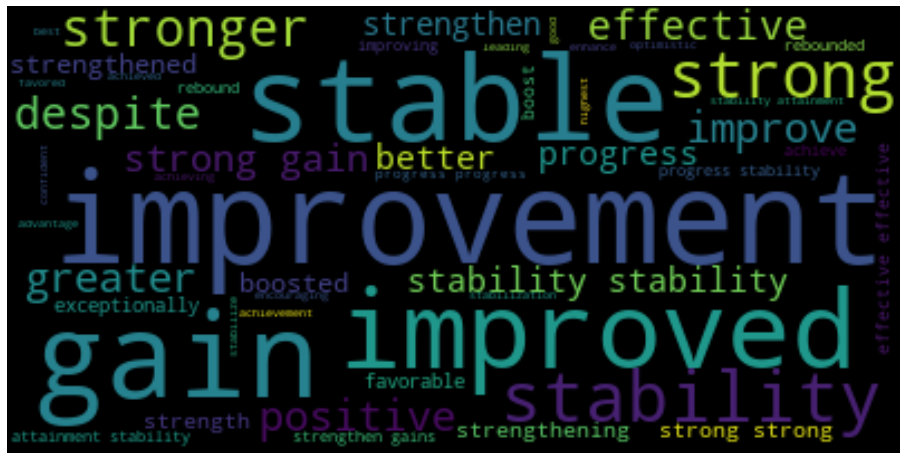

In [140]:
minutes = df_FOMC_sentiment[df_FOMC_sentiment['document_type'] == 'minutes']

plt.figure(figsize=(16, 10))

postive_words = ' '.join(minutes['LM_positive_words'].apply(lambda words: ' '.join(words)))
postive_words_wordcloud = WordCloud(max_words=50).generate(postive_words)
# minute_wordcloud = WordCloud(max_words=50, background_color='white').generate(minute_text)
plt.imshow(postive_words_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_minutes_wordcloud.png"

# Pretrained FinBERT Sentiment Analysis

In [141]:
## Load required packages
# pip install torch torchvision
# pip install torch==1.7.0 -f https://download.pytorch.org/whl/torch_stable.html

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
# import numpy as np

In [142]:
## Downloads pretrained finBERT model

tokenizer = AutoTokenizer.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")
model = AutoModelForSequenceClassification.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")

In [143]:
def finBERTModelPreTrained(review_text):
    MAX_LEN = 160
    class_names = ['negative', 'neutral', 'positive']

    encoded_new = tokenizer.encode_plus(
                            review_text,                      # Sentence to encode.
                            add_special_tokens = True,        # Add '[CLS]' and '[SEP]'
                            max_length = MAX_LEN,             # Pad & truncate all sentences.
                            padding = 'longest',
                            truncation=True,
                            return_attention_mask = True,     # Construct attn. masks.
                            return_tensors = 'pt',            # Return pytorch tensors.
                       )

    # Add the encoded sentence to the list.    
    input_idst = (encoded_new['input_ids'])
    attention_maskst = (encoded_new['attention_mask'])

    # Convert the lists into tensors.
    input_idst = torch.cat([input_idst], dim=0)
    attention_maskst = torch.cat([attention_maskst], dim=0)


    new_test_output = model(input_idst, token_type_ids=None, 
                          attention_mask=attention_maskst)

    logits = new_test_output[0]
    predicted = logits.detach().numpy()

    # Store predictions
    flat_predictions = np.concatenate(predicted, axis=0)

    # For each sample, pick the label (0 or 1) with the higher score.
    new_predictions = np.argmax(flat_predictions).flatten()

    return class_names[new_predictions[0]]

### Pretrained FinBERT Model on Entire Document

In [144]:
df_FOMC_sentiment['FinBERT_pretrained_sentiment_score'] = df_FOMC_sentiment['document_data'].apply(lambda data: finBERTModelPreTrained(data))

In [147]:
df_FOMC_sentiment.groupby(['document_type', 'FinBERT_pretrained_sentiment_score', 'label']).count()

FOMC_date  \
document_type FinBERT_pretrained_sentiment_score label              
minutes       neutral                            -3             3   
                                                 -2            20   
                                                 -1             7   
                                                  0            23   
                                                  1             6   
                                                  2            25   
                                                  3             2   
statement     negative                           -3             1   
                                                 -1             1   
                                                  0             1   
              neutral                            -3             2   
                                                 -2             9   
                                                 -1             4   
                                                  0            19   
                                                  1             2   
                                                  2             4   
                                                  3             1   
              positive                           -3             1   
                                                 -2             3   
                                                 -1             5   
                                                  0            16   
                                                  1             1   
                                                  2            13   
                                                  3             2   

                                                        document_data  \
document_type FinBERT_pretrained_sentiment_score label                  
minutes       neutral                            -3                 3   
                                                 -2                20   
                                                 -1                 7   
                                                  0                23   
                                                  1                 6   
                                                  2                25   
                                                  3                 2   
statement     negative                           -3                 1   
                                                 -1                 1   
                                                  0                 1   
              neutral                            -3                 2   
                                                 -2                 9   
                                                 -1                 4   
                                                  0                19   
                                                  1                 2   
                                                  2                 4   
                                                  3                 1   
              positive                           -3                 1   
                                                 -2                 3   
                                                 -1                 5   
                                                  0                16   
                                                  1                 1   
                                                  2                13   
                                                  3                 2   

                                                        press_conference  \
document_type FinBERT_pretrained_sentiment_score label                     
minutes       neutral                            -3                    3   
                                                 -2                   20   
                                                 -1       

### Pretrained FinBERT Model on Each Sentence

In [95]:
from nltk import tokenize

def FinBERTModel_sentences(document):
    sentences = tokenize.sent_tokenize(document)
    sentiment_score = 0
    for sentence in sentences:
        sentiment = finBERTModelPreTrained(sentence)
        if sentiment == 'negative':
            sentiment_score -= 1
        elif sentiment == 'positive':
            sentiment_score += 1
    return sentiment_score

# df_FOMC['by_sentence_FinBERT_sentiment_score'] = df_FOMC['document_data'].apply(lambda data: FinBERTModel_sentences(data))

### Pretrained FinBERT Model Output Review

In [94]:
# df_FOMC.groupby(['document_type', 'FinBERT_sentiment_score', 'by_sentence_FinBERT_sentiment_score','sentiment_score']).count()

# df_FOMC.to_csv('/Users/Lex/Documents/Berkeley/266_nlp/266FinalProject_v2/266FinalProject/FinBERTandLMSimpleSentimentScores.csv', index = False, header=True)


# FinBERT Sentiment Analysis

In [80]:
# pip install pytorch_pretrained_bert
# pip install finbert-embedding==0.1.4

In [79]:
# from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE
# from pytorch_pretrained_bert.modeling import BertForSequenceClassification
# from pytorch_pretrained_bert.tokenization import BertTokenizer
# from pytorch_pretrained_bert.optimization import *

# from finbert_embedding.embedding import *

In [148]:
# WATCH VIDEO
# https://towardsdatascience.com/how-nlp-has-evolved-for-financial-sentiment-analysis-fb2990d9b3ed

In [149]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

In [152]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [186]:
model = BertForSequenceClassification.from_pretrained('finBERT/pytorch_model.bin', config = 'finBERT/config.json', num_labels = 3)

label_lists = ['positive', 'negative', 'neutral']

# RuntimeError: Error(s) in loading state_dict for BertForSequenceClassification:
# 	size mismatch for classifier.weight: copying a param with shape torch.Size([3, 768]) from checkpoint, the shape in current model is torch.Size([2, 768]).
# 	size mismatch for classifier.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).
    # FIX: add num_labels=3 to the parameters above

### Simple Tests for Accuracy

In [182]:
# TESTS
inputs = tokenizer("We had a good year", return_tensors="pt")
outputs = model(**inputs)
outputs
# Ouputs = [positive, negative, neutral]

label_lists[torch.argmax(outputs[0])]

'positive'

In [184]:
# TESTS
inputs = tokenizer("We had a bad year", return_tensors="pt")
outputs = model(**inputs)
label_lists[torch.argmax(outputs[0])]

'negative'

In [187]:
# TESTS
inputs = tokenizer("We had a neutral year", return_tensors="pt")
outputs = model(**inputs)
label_lists[torch.argmax(outputs[0])]

'neutral'

### Run Data through Model

In [193]:
def runFinBERT(document):
    inputs = tokenizer(document, return_tensors="pt", truncation = True, max_length = 512)
    outputs = model(**inputs)
    return label_lists[torch.argmax(outputs[0])]

In [194]:
df_FOMC_sentiment['FinBERT_video_sentiment_score'] = df_FOMC_sentiment['document_data'].apply(lambda data: runFinBERT(data))

# RuntimeError: The size of tensor a (5261) must match the size of tensor b (512) at non-singleton dimension 1
    # too many tokens in data...need to truncate or shorten the data into smaller subsections of length 512 and less
    # if you truncate, you need to add truncation = True and max_length = 512 as a parameter in your tokenizer 

In [196]:
df_FOMC_sentiment.groupby(['document_type', 'FinBERT_video_sentiment_score','FinBERT_pretrained_sentiment_score', 'label']).count()

# loss = outputs.loss
# logits = outputs.logits

FOMC_date  \
document_type FinBERT_video_sentiment_score FinBERT_pretrained_sentiment_score label              
minutes       neutral                       neutral                            -3             3   
                                                                               -2            20   
                                                                               -1             7   
                                                                                0            23   
                                                                                1             6   
                                                                                2            25   
                                                                                3             2   
statement     neutral                       negative                           -3             1   
                                                                               -1             1   
                                                                                0             1   
                                            neutral                            -3             2   
                                                                               -2             9   
                                                                               -1             4   
                                                                                0            19   
                                                                                1             2   
                                                                                2             4   
                                                                                3             1   
                                            positive                           -3             1   
                                                                               -2             3   
                                                                               -1             5   
                                                                                0            16   
                                                                                1             1   
                                                                                2            12   
                                                                                3             2   
              positive                      positive                            2             1   

                                                                                      document_data  \
document_type FinBERT_video_sentiment_score FinBERT_pretrained_sentiment_score label                  
minutes       neutral                       neutral                            -3                 3   
                                                                               -2                20   
                                                                               -1                 7   
                                                                                0                23   
                                                                                1                 6   
                                                                                2                25   
                                                                                3                 2   
statement     neutral                       negative                           -3                 1   
                                                                               -1                 1   
                                                                                0                 1   
                                            neutral                            -3                 2   
                                                                         